In [111]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import scipy
import time
import gget
from sklearn.decomposition import PCA
from kneed import KneeLocator
from importlib import reload
import scipy.cluster.hierarchy as shc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.patheffects as pe

"""WARNING: disabling future warnings"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # and to omit tensorflow logging

""" Increase scanpy output"""
sc.settings.verbosity = 3

# local 
import utils as ut
reload(ut)

<module 'utils' from '/home/cstansbu/git_repositories/MC3R/notebooks/utils.py'>

In [2]:
fullpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/processed_data/all_subclustered.h5ad"
raw = sc.read(fullpath)

pdf = raw.copy()
pdf

AnnData object with n_obs × n_vars = 33647 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes', 'color', 'leiden', 'cluster_num', 'Cluster', 'cluster_cat', 'U1', 'U2', 'cell_type', 'neuron_clusters', 'neuron_cluster_num', 'neuron_cluster_name', 'neuron_cluster_cat', 'NU1', 'NU2'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cluster', 'Cluster_colors', 'batch_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'neuron_clusters_colors', 'neuron_clusters_sizes', 'neuron_neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'neuron_neighbors_connectivities', 'neuron_neighbors_distances'

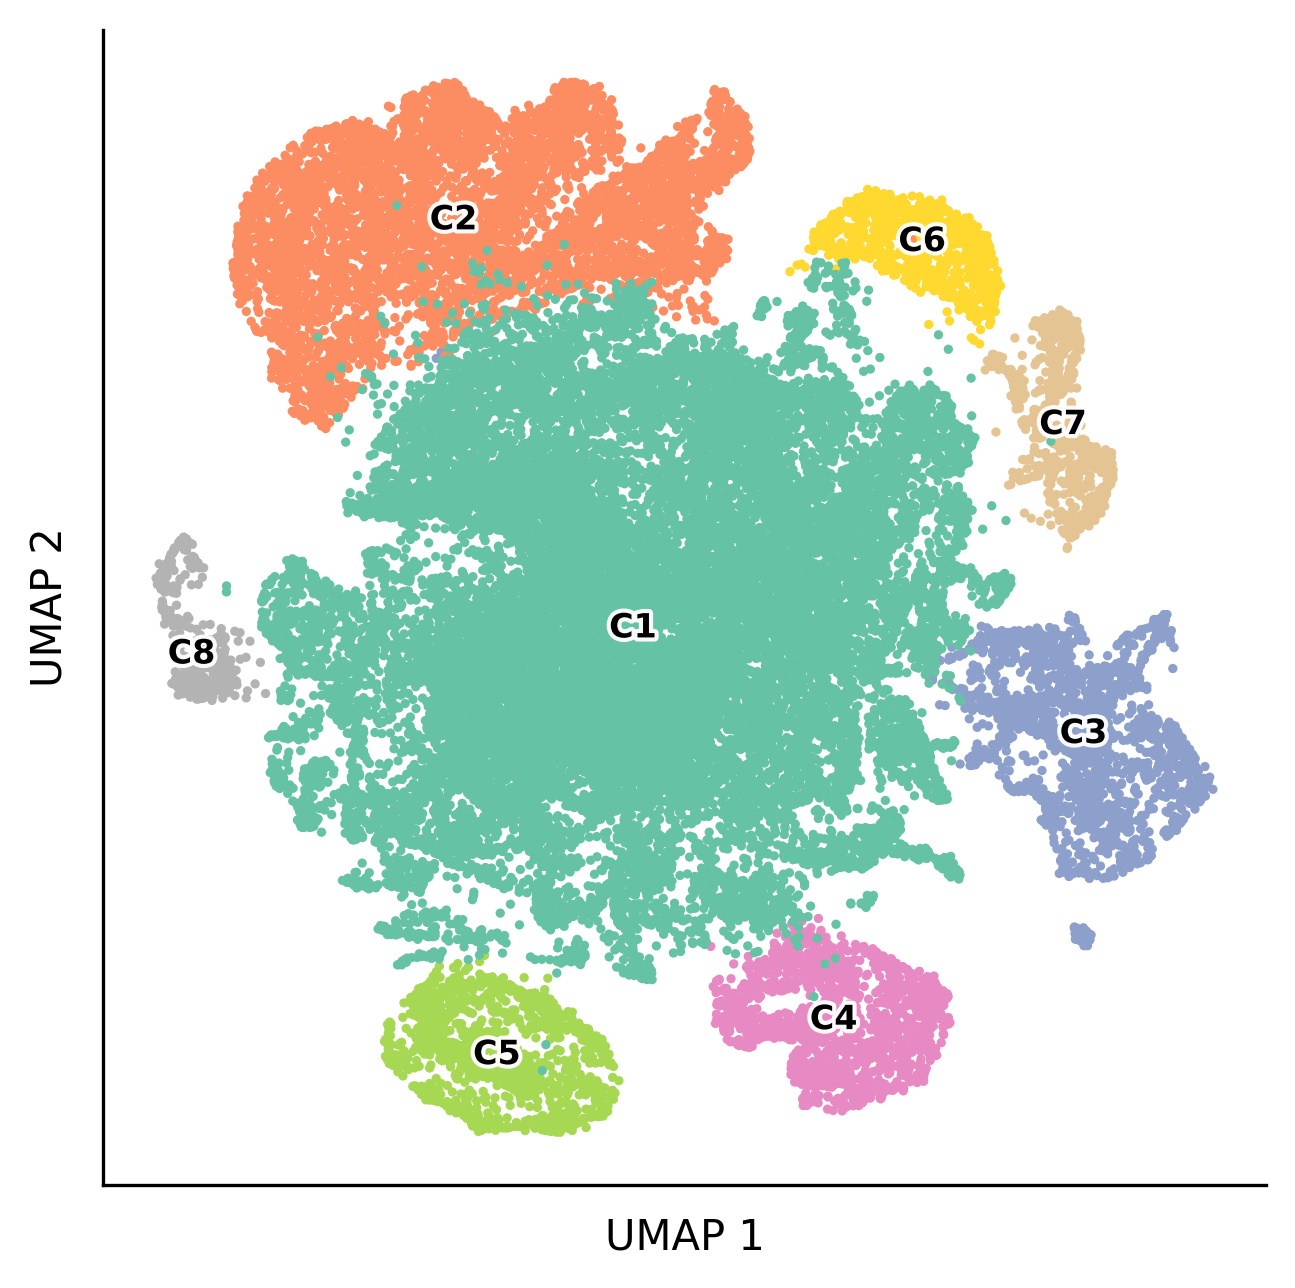

In [3]:
color_map = "Set2"

""" UMAP PLOT """
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

# sort the data frame
pdx = pdf.obs.copy()
pdx = pdx.sort_values(by='cell_type')
pdx = pdx.reset_index()

hue_order = sorted(pdx['neuron_cluster_name'].unique())
order = np.argsort(pdx['neuron_cluster_name'])[::-1]

sns.scatterplot(data=pdx.iloc[order],
                x='NU1',
                y='NU2',
                hue='neuron_cluster_name',
                hue_order=hue_order,
                palette=color_map,
                s=5,
                alpha=1.0,
                ec='none'
        )

sns.despine()
plt.xticks([])
plt.yticks([])

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# label on data
ax = plt.gca()

all_pos = (
        pdx.groupby('neuron_cluster_name')[['NU1', 'NU2']]
        .median()
        .sort_index()
    )

for label, x_pos, y_pos in all_pos.itertuples():
    ax.text(
        x_pos,
        y_pos,
        label,
        weight='bold',
        path_effects=[pe.withStroke(linewidth=2, foreground="w", alpha=0.95,)],
        verticalalignment="center",
        horizontalalignment="center",
        fontsize='8',
    )

plt.gca().legend().remove()


# outpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/analysis_files/figures/neuron_cluster_umap.png"
# plt.savefig(outpath)
# print(f"saved: {outpath}")

# By sex by diet

In [8]:
key = 'batch'

# get marker genes
sc.tl.rank_genes_groups(pdf, 
                        groupby=key,
                        method='wilcoxon',
                        key_added=key,
                        corr_method='benjamini-hochberg')

deg = sc.get.rank_genes_groups_df(pdf, 
                                  group=None,
                                  key=key)

deg['Sex'] = deg['group'].apply(lambda x: x.split("_")[1])
deg['Diet'] = deg['group'].apply(lambda x: x.split("_")[0])

deg.head()

ranking genes
    finished: added to `.uns['batch']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:49)


,group,names,scores,logfoldchanges,pvals,pvals_adj,Sex,Diet
0,fasted_f,Xist,98.836716,6.501098,0.0,0.0,f,fasted
1,fasted_f,Tsix,75.157883,4.279603,0.0,0.0,f,fasted
2,fasted_f,Npy,57.569672,4.006341,0.0,0.0,f,fasted
3,fasted_f,Gm26917,46.223484,1.918898,0.0,0.0,f,fasted
4,fasted_f,Ptbp2,42.271713,1.060268,0.0,0.0,f,fasted


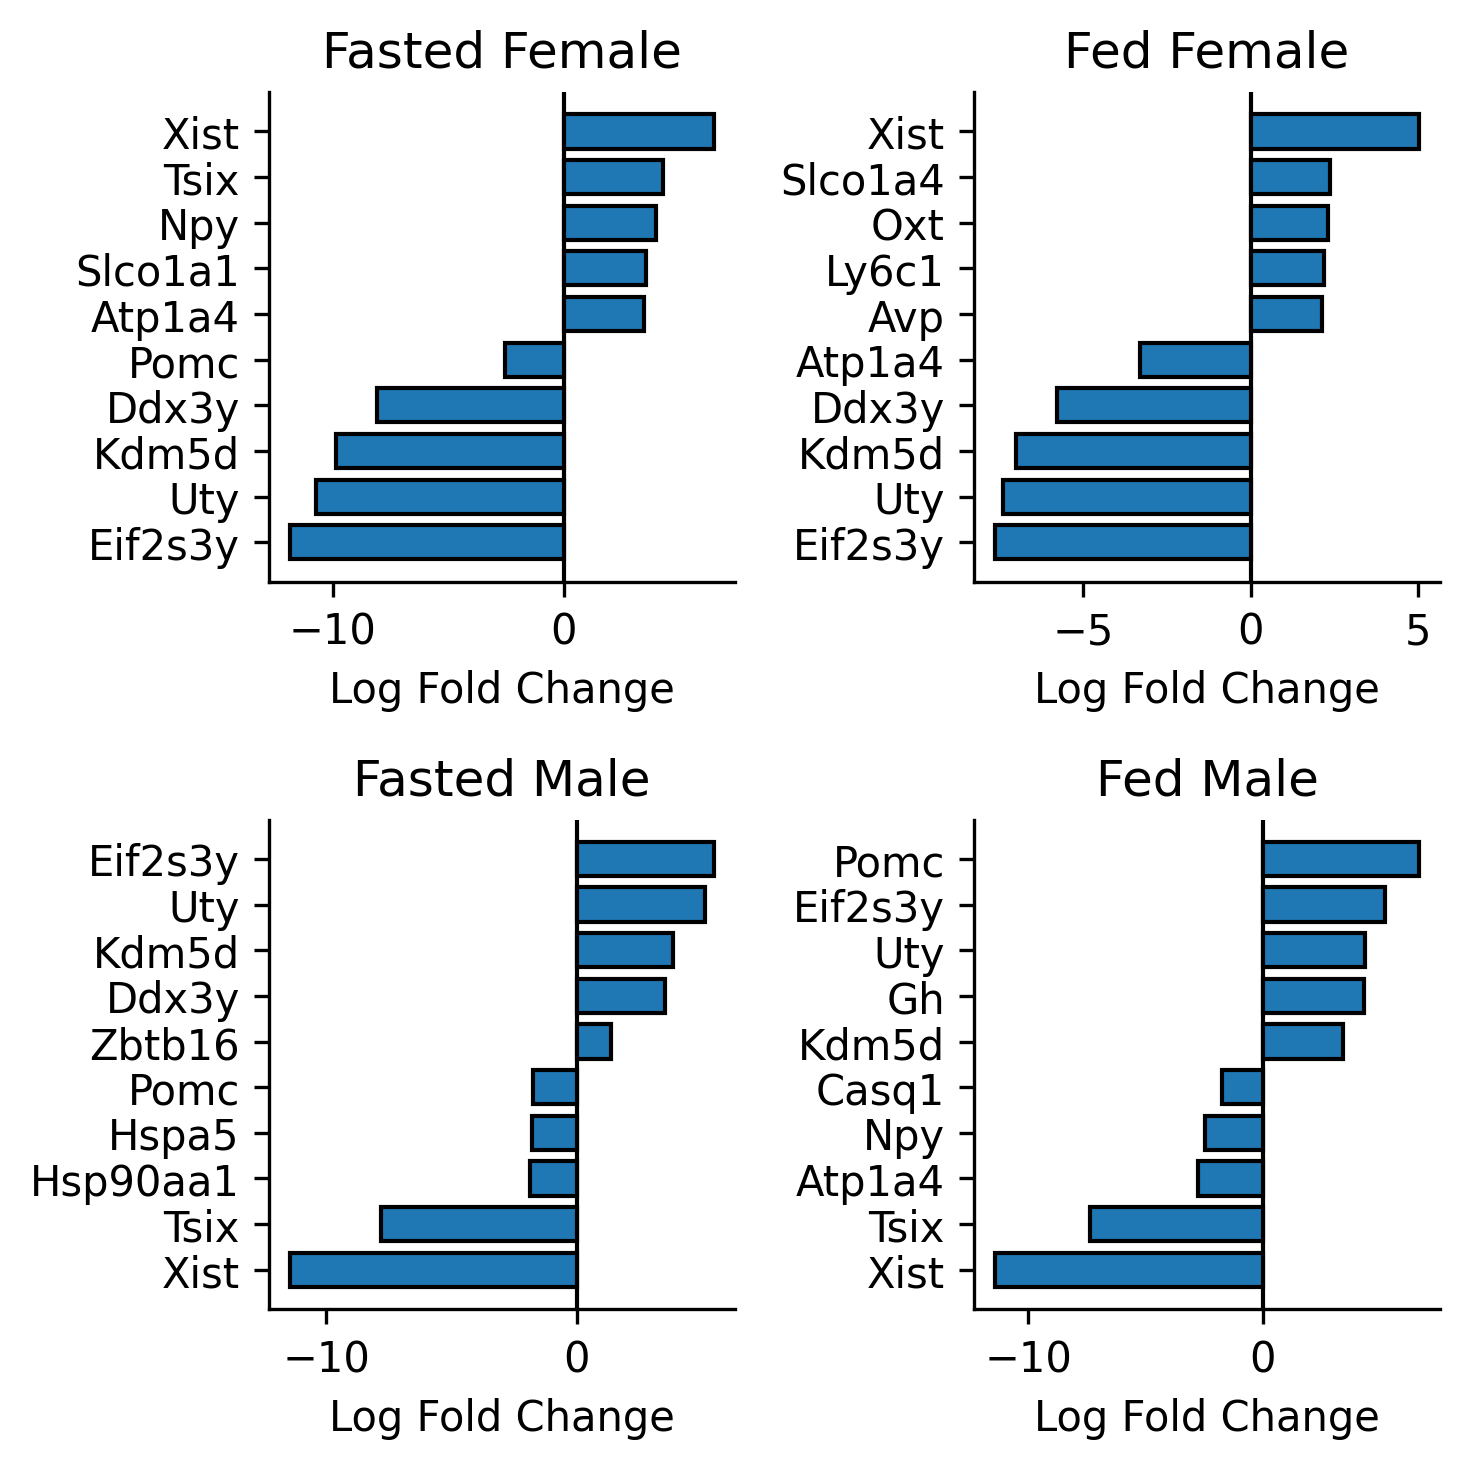

In [46]:

def get_data_table(df, n=10, logfold_change=1.5, alpha=0.05):
    """Generates a data table and plots for differentially expressed genes.

    Args:
        df (pd.DataFrame): Input DataFrame containing 'names', 'pvals_adj',
                           'Sex', 'Diet', and 'logfoldchanges' columns.
        n (int, optional): Number of top genes to display per group. Defaults to 10.
        logfold_change (float, optional): Log fold change threshold. Defaults to 1.5.
        alpha (float, optional): Significance level (adjusted p-value threshold). Defaults to 0.05.
    """

    def filter_genes(df):
        """Filters out unwanted genes based on their names."""
        return df[
            (~df['names'].str.startswith("Gm")) &
            (~df['names'].str.startswith("mt")) &
            (~df['names'].str.endswith("Rik"))
        ].reset_index(drop=True)

    def select_top_and_bottom_genes(df):
        """Selects top and bottom 'n' genes within each group."""
        def select_subset(x): 
            return pd.concat([x.nlargest(n, 'logfoldchanges'),
                              x.nsmallest(n, 'logfoldchanges')])
        return df.groupby(['Sex', 'Diet']).apply(select_subset).reset_index(drop=True)


    # Data preprocessing
    df_filtered = filter_genes(df.copy())  
    df_filtered = df_filtered[df_filtered['pvals_adj'] <= alpha]
    df_sorted = select_top_and_bottom_genes(df_filtered)

    # Mapping for labels
    diet_map = {'fasted': 'Fasted', 'fed': 'Fed'}
    sex_map = {'f': 'Female', 'm': 'Male'}

    # Create subplots
    for i, (name, group) in enumerate(df_sorted.groupby(['Sex', 'Diet'])):
        group = group.sort_values(by='logfoldchanges')
        plt.subplot(2, 2, i + 1)
        title = f"{diet_map[name[1]]} {sex_map[name[0]]}"
        plt.barh(range(len(group)), 
                 group['logfoldchanges'], 
                 height=0.75,
                 tick_label=group['names'],
                 zorder=1,
                 ec='k')
        plt.xlabel('Log Fold Change')
        plt.axvline(x=0, c='k', zorder=0, lw=1)
        plt.ylabel('')
        plt.title(title)
    
    sns.despine()
    plt.tight_layout()
    plt.show()  


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
get_data_table(deg, n=5, logfold_change=1.5, alpha=0.05)

group            fasted_f   fasted_m      fed_f     fed_m
names                                                    
1700047I17Rik2  -2.306118   1.318258  -2.049458  1.558644
2610044O15Rik8  -0.164101   0.252463  -0.028742 -0.042008
4930594M22Rik-1 -0.338761   0.496985  -0.481193  0.359079
9930111J21Rik1   1.143802 -18.602144 -18.638775  2.138529
9930111J21Rik2  -0.712876  -1.290351   0.906376  0.721628
Index(['Fasted Female', 'Fasted Male', 'Fed Female', 'Fed Male'], dtype='object')


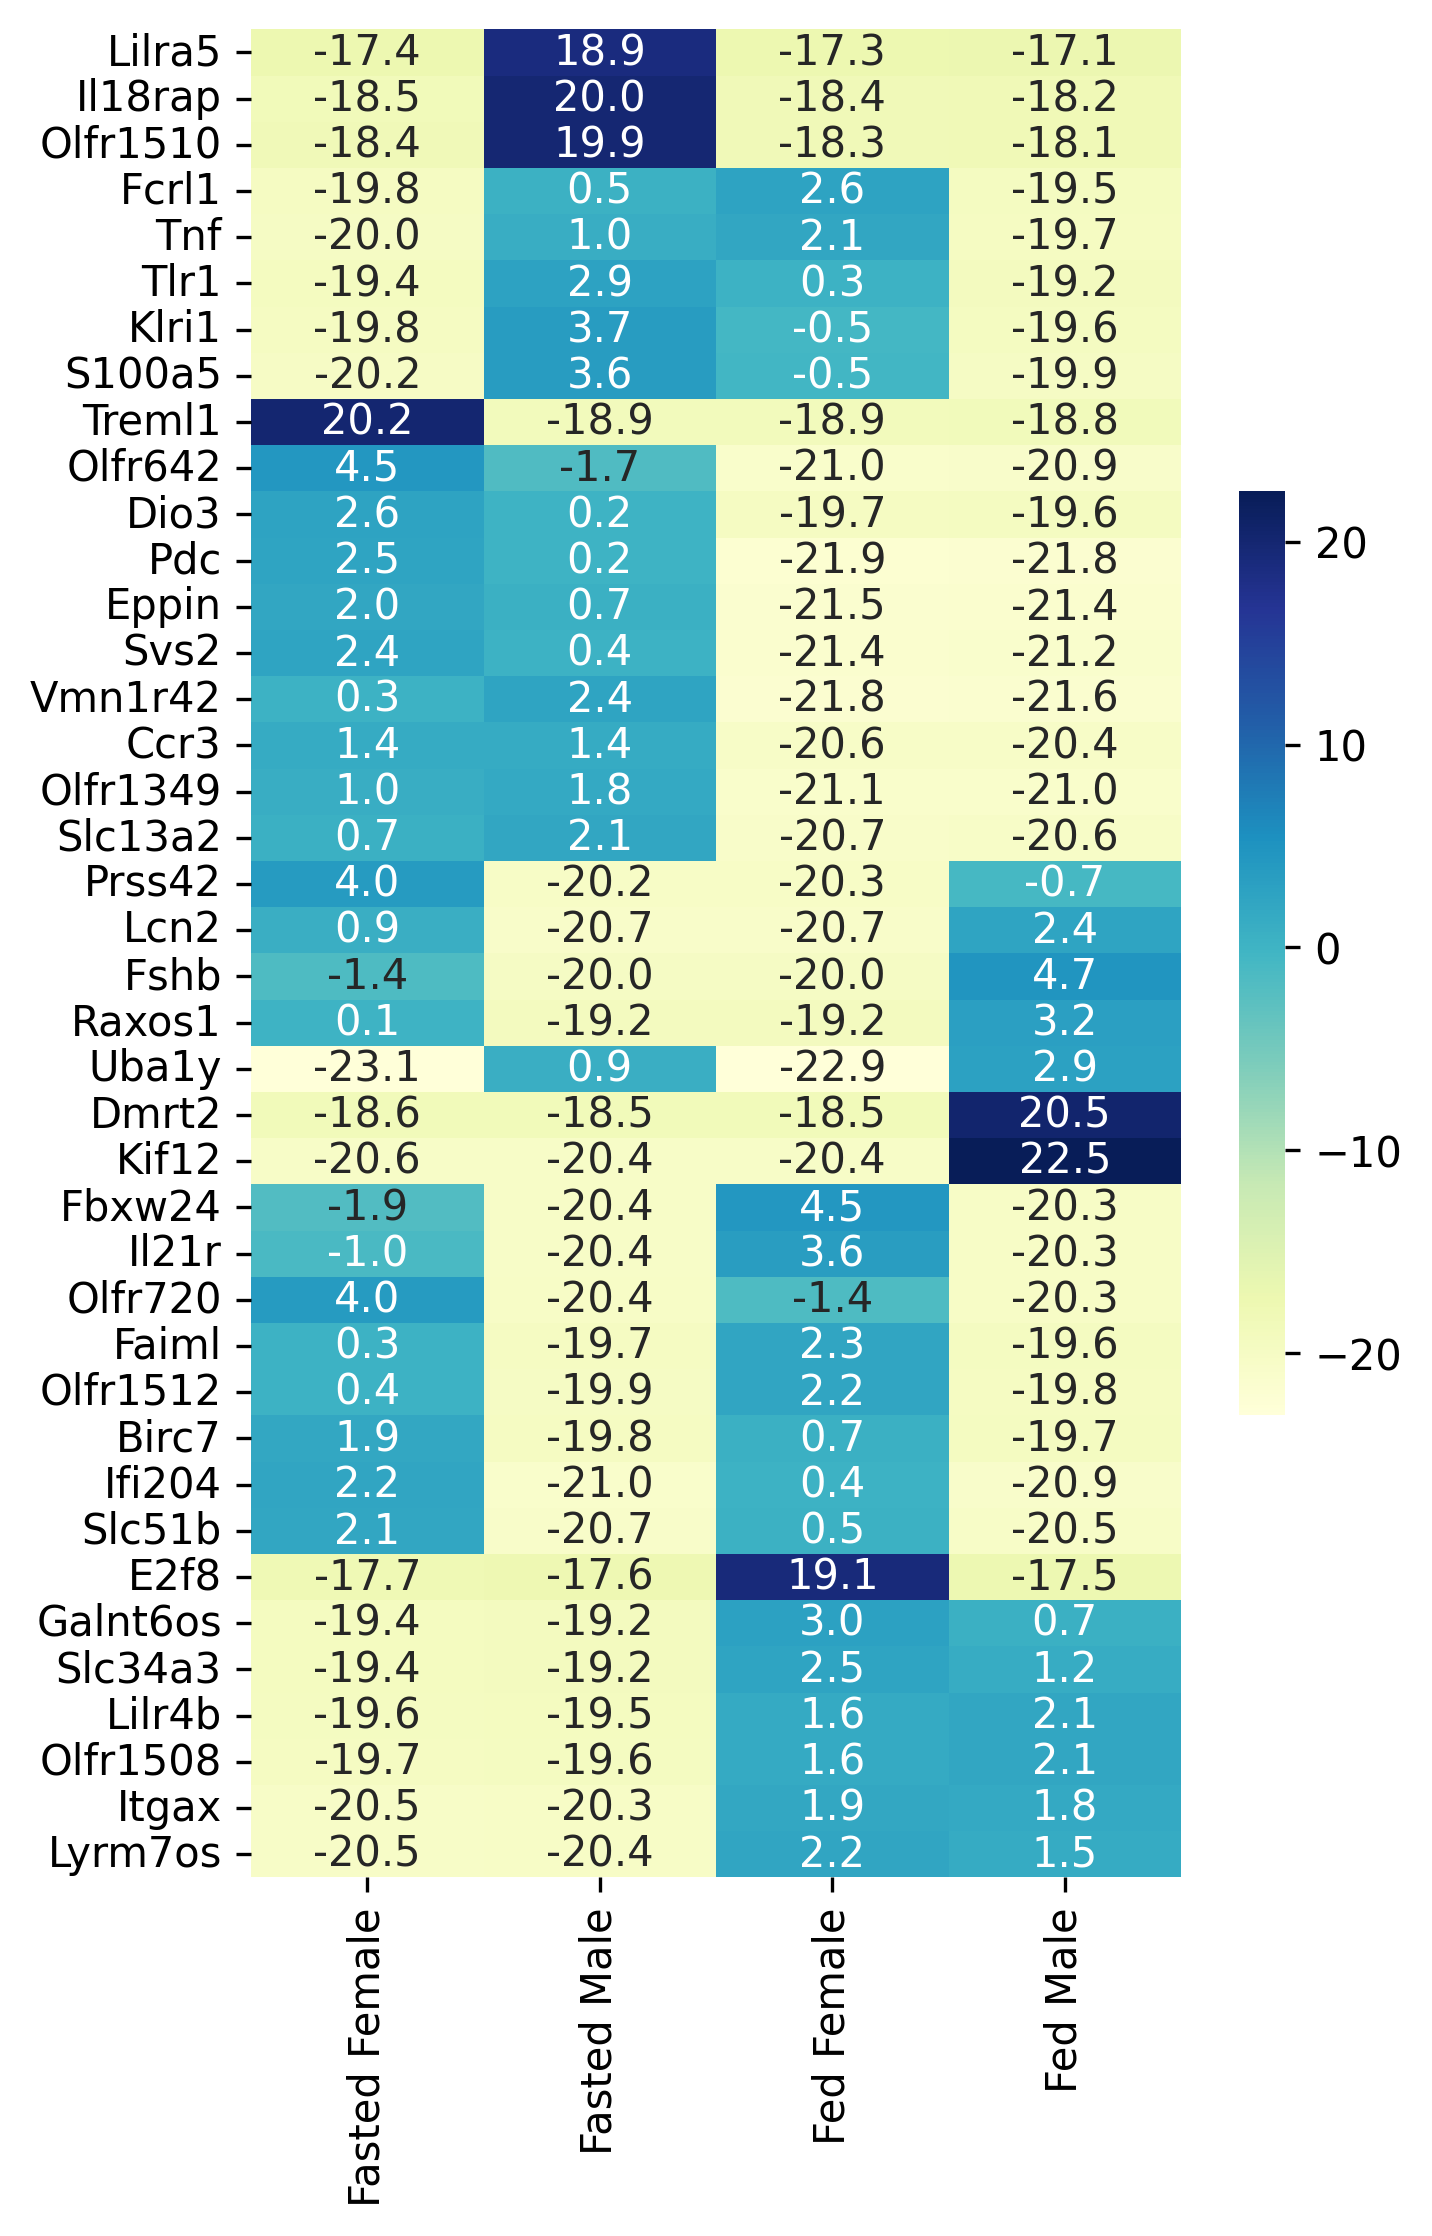

In [160]:
def filter_genes(df):
    """Filters out unwanted genes based on their names."""
    return df[
        (~df['names'].str.startswith("Gm")) &
        (~df['names'].str.startswith("mt")) &
        (~df['names'].str.endswith("Rik")) 
    ].reset_index(drop=True)


def sort_heatmap(df, method='average', metric='euclidean', sort_rows=True, sort_cols=True):
    """Sorts a DataFrame by hierarchical clustering.

    Args:
        df (pd.DataFrame): Input DataFrame containing numerical data.
        method (str, optional): Linkage method for clustering. Defaults to 'average'.
        metric (str, optional): Distance metric for clustering. Defaults to 'euclidean'.
        sort_rows (bool, optional): Sort rows if True. Defaults to True.
        sort_cols (bool, optional): Sort columns if True. Defaults to True.

    Returns:
        pd.DataFrame: The sorted DataFrame.
    """

    # Calculate linkages (if sorting is enabled)
    if sort_rows:
        row_linkage = shc.linkage(df, method=method, metric=metric)
        row_order = shc.dendrogram(row_linkage, no_plot=True)['leaves']
    if sort_cols:
        col_linkage = shc.linkage(df.T, method=method, metric=metric)
        col_order = shc.dendrogram(col_linkage, no_plot=True)['leaves']

    # Apply sorting (conditionally)
    df_sorted = df.copy()  # Avoid modifying the input DataFrame in-place
    if sort_rows:
        df_sorted = df_sorted.iloc[row_order, :]
    if sort_cols:
        df_sorted = df_sorted.iloc[:, col_order]

    return df_sorted

def plot_diffs(df, n=20, alpha=0.05, names=None):
    df = filter_genes(df)
    df = pd.pivot_table(df, 
                        index='names',
                        columns='group',
                        values='logfoldchanges')

    if names is not None:
        # Use provided 'names'
        df = df.loc[names].reset_index().melt(
        id_vars='names', var_name='condition', value_name='value').pivot('names', 'condition', 'value')
    else:
        # Select top 'n' genes by variance
        top_genes = df.var(axis=1).nlargest(n).index
        df_meldfted = df.loc[top_genes].reset_index().melt(
        id_vars='names', var_name='condition', value_name='value').pivot('names', 'condition', 'value')


    print(df.head())     
    # Calculate variances for each name across the float32 columns
    variances = df.var(axis=1)
    
    # Select the names with the largest variances
    top_names = variances.nlargest(n).index  # Change 2 to the number of top names you want to plot
    
    # Filter the dataframe to include only the selected names
    df_filtered = df[df.index.isin(top_names)]    
    df_filtered = df_filtered.reset_index()
    
    # Reshape the dataframe for plotting
    df_melted = df_filtered.melt(id_vars='names', var_name='condition', value_name='value')
    df_melted = df_melted.pivot('names', 'condition', 'value')

    df_melted = sort_heatmap(df_melted, sort_cols=False)

    tickmap = { 
        'fasted_f' : 'Fasted Female',  
        'fasted_m' : 'Fasted Male',
        'fed_f' : 'Fed Female',  
        'fed_m': 'Fed Male',  
    }
    df_melted.columns = [tickmap[x] for x in df_melted.columns]
    
    heatmap = sns.heatmap(df_melted,
                          cmap='YlGnBu', 
                          annot=True, 
                          fmt=".1f",
                          cbar_kws={'shrink' : 0.5}) 
    
    print(df_melted.columns)
    plt.ylabel("")
    plt.xlabel("")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 8
plot_diffs(deg, n=40)

len(neuropeptides)=52
condition  fasted_f  fasted_m     fed_f     fed_m
names                                            
Adcyap1    0.455699 -0.732466  0.456273 -0.454957
Adm       -0.308239 -0.009935  0.422257 -0.144702
Agrp       2.073621 -0.127599 -1.529558 -1.033141
Agt       -0.050776  0.046580 -0.126535  0.172693
Apln      -0.253715 -0.603297  0.852773 -0.234793
Index(['Fasted Female', 'Fasted Male', 'Fed Female', 'Fed Male'], dtype='object')


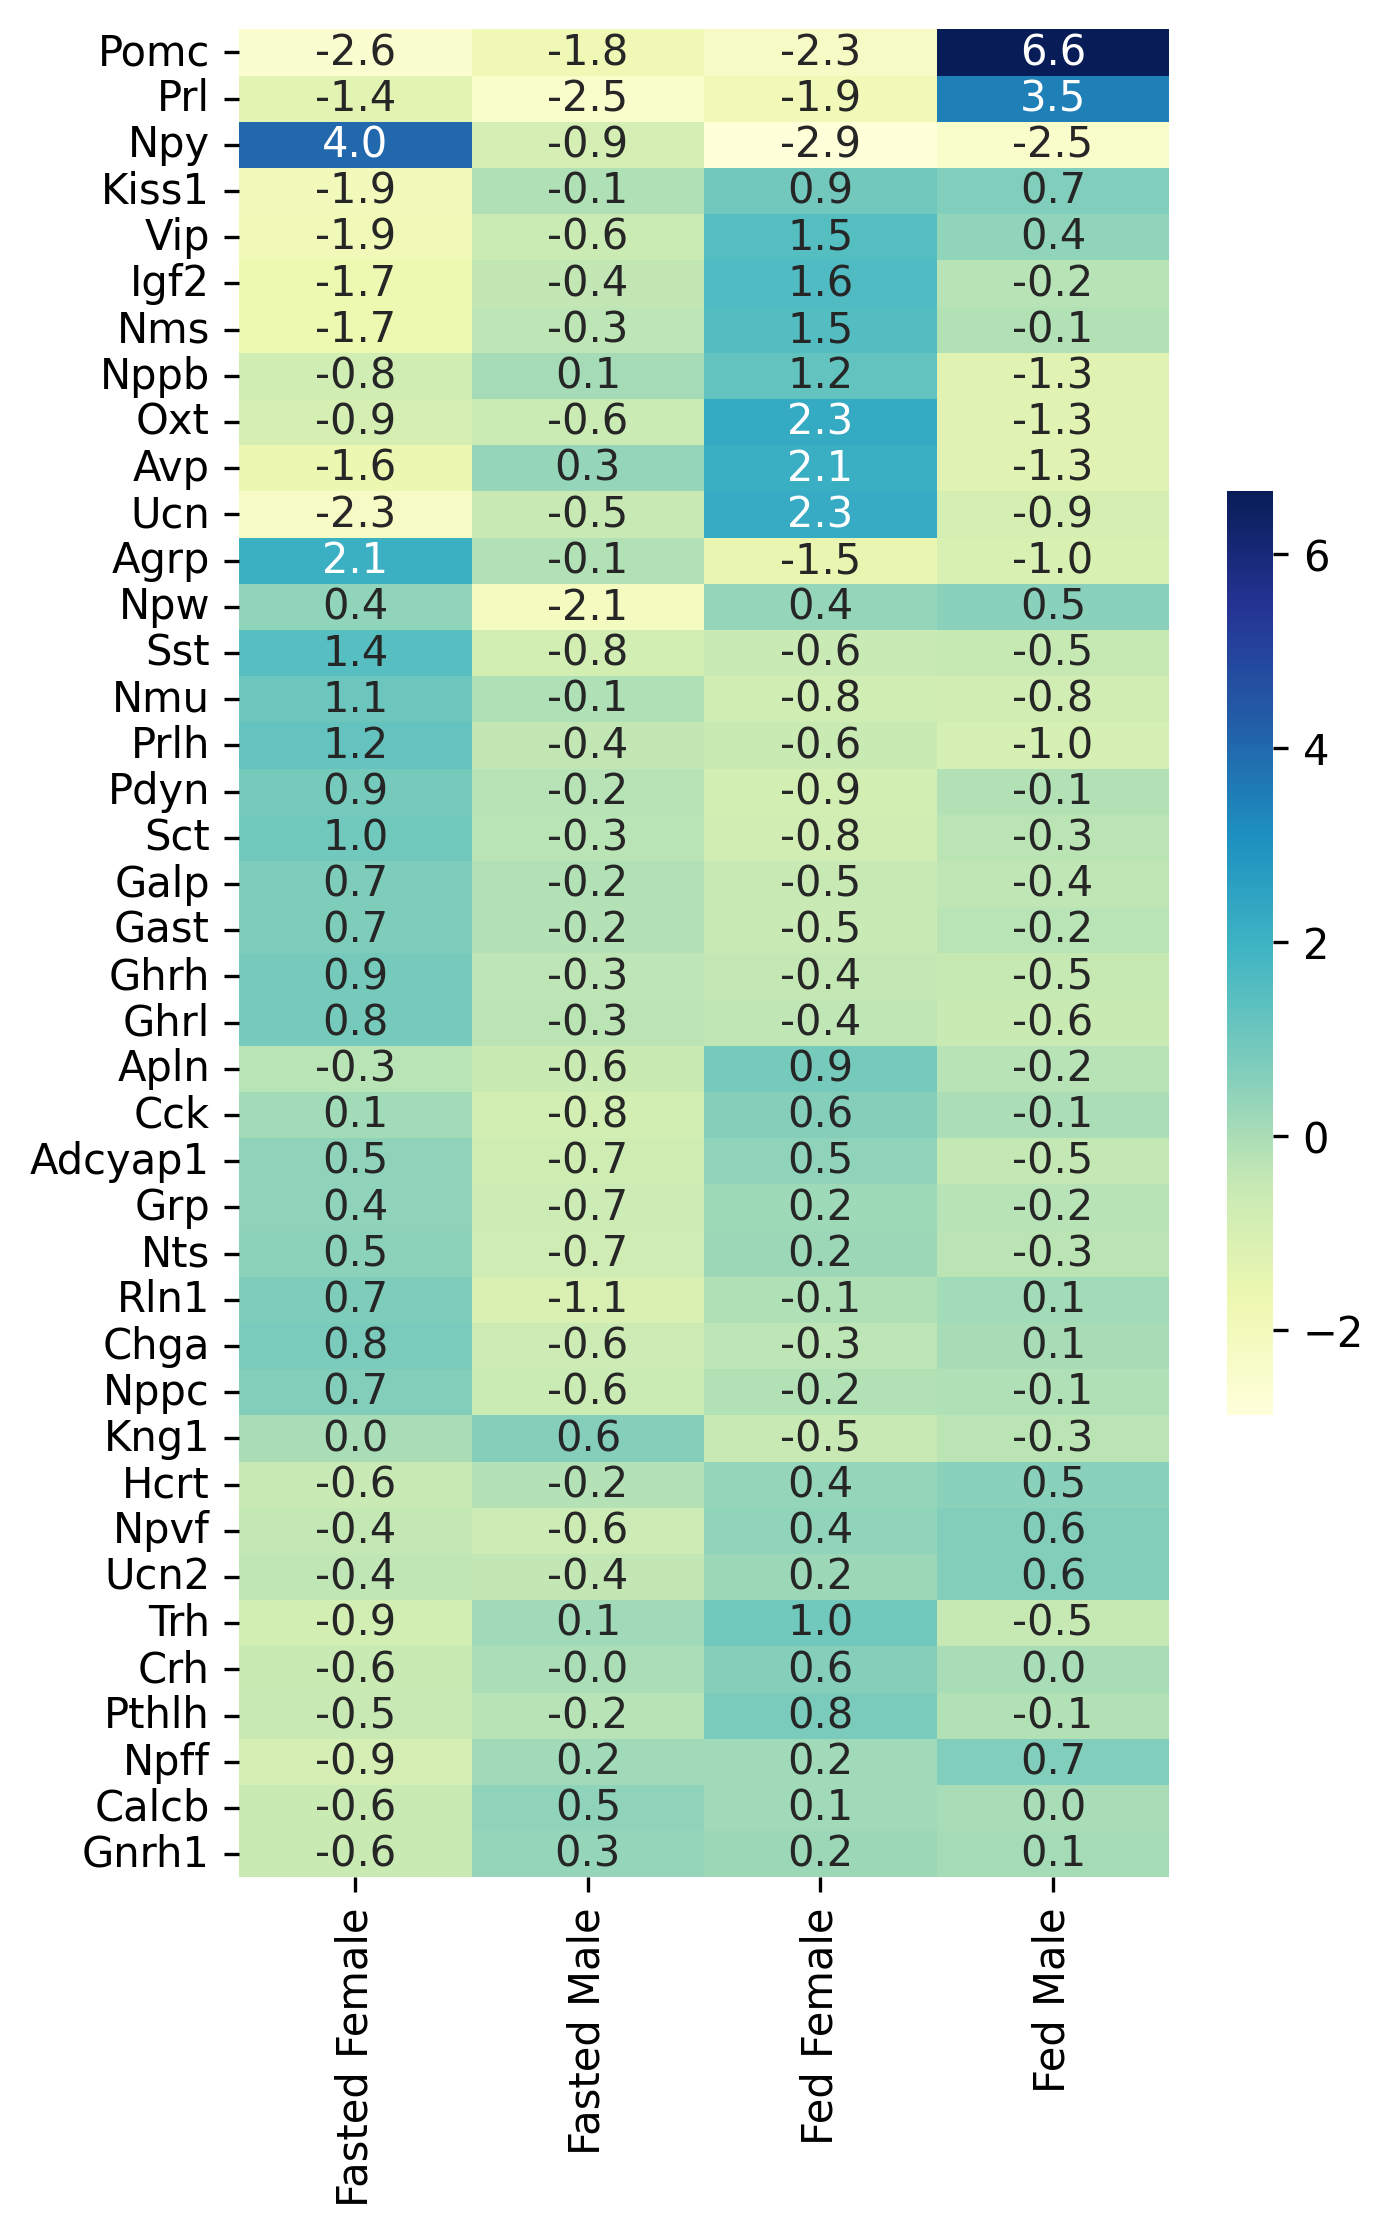

In [161]:
# load neuropeptides
pep_path = "/nfs/turbo/umms-indikar/shared/projects/MC3R/neuropeptides/group-1902.csv"
ndf = pd.read_csv(pep_path, skiprows=1)

neuropeptides = ndf['Approved symbol'].unique()
neuropeptides = [x.lower().capitalize() for x in neuropeptides]
neuropeptides = [x for x in neuropeptides if x in pdf.var.index.to_list()]
neuropeptides.remove('Nps')

print(f"{len(neuropeptides)=}")

plot_diffs(deg, n=40, names=neuropeptides)

In [173]:
# cluster-specific neuropeptide DEG
cdf = pdf.copy()
cdf = cdf[:, neuropeptides]

res = []

for cluster in sorted(cdf.obs['neuron_cluster_name'].unique()):
    
    cdf2 = cdf[cdf.obs['neuron_cluster_name'] == cluster].copy()
    
    key = f'{cluster}_fed_by_sex'

    sc.tl.rank_genes_groups(cdf2, 
                            groupby='batch',
                            method='wilcoxon',
                            key_added=key,
                            corr_method='benjamini-hochberg')

    deg = sc.get.rank_genes_groups_df(cdf2, 
                                      group=None,
                                      key=key)
    
    deg['cluster'] = cluster
    res.append(deg)

res = pd.concat(res)
print(f"{res.shape=}")
res.head()

ranking genes
    finished: added to `.uns['C1_fed_by_sex']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['C2_fed_by_sex']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['C3_fed_by_sex']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by gr

,group,names,scores,logfoldchanges,pvals,pvals_adj,cluster
0,fasted_f,Npy,42.373573,3.870281,0.000000e+00,0.000000e+00,C1
1,fasted_f,Agrp,24.790010,1.600934,1.148947e-135,2.987262e-134,C1
2,fasted_f,Sst,18.154373,1.516160,1.185742e-73,1.541464e-72,C1
3,fasted_f,Chga,17.492680,1.044834,1.629164e-68,1.694331e-67,C1
4,fasted_f,Adcyap1,6.279762,0.634637,3.390910e-10,2.204091e-09,C1


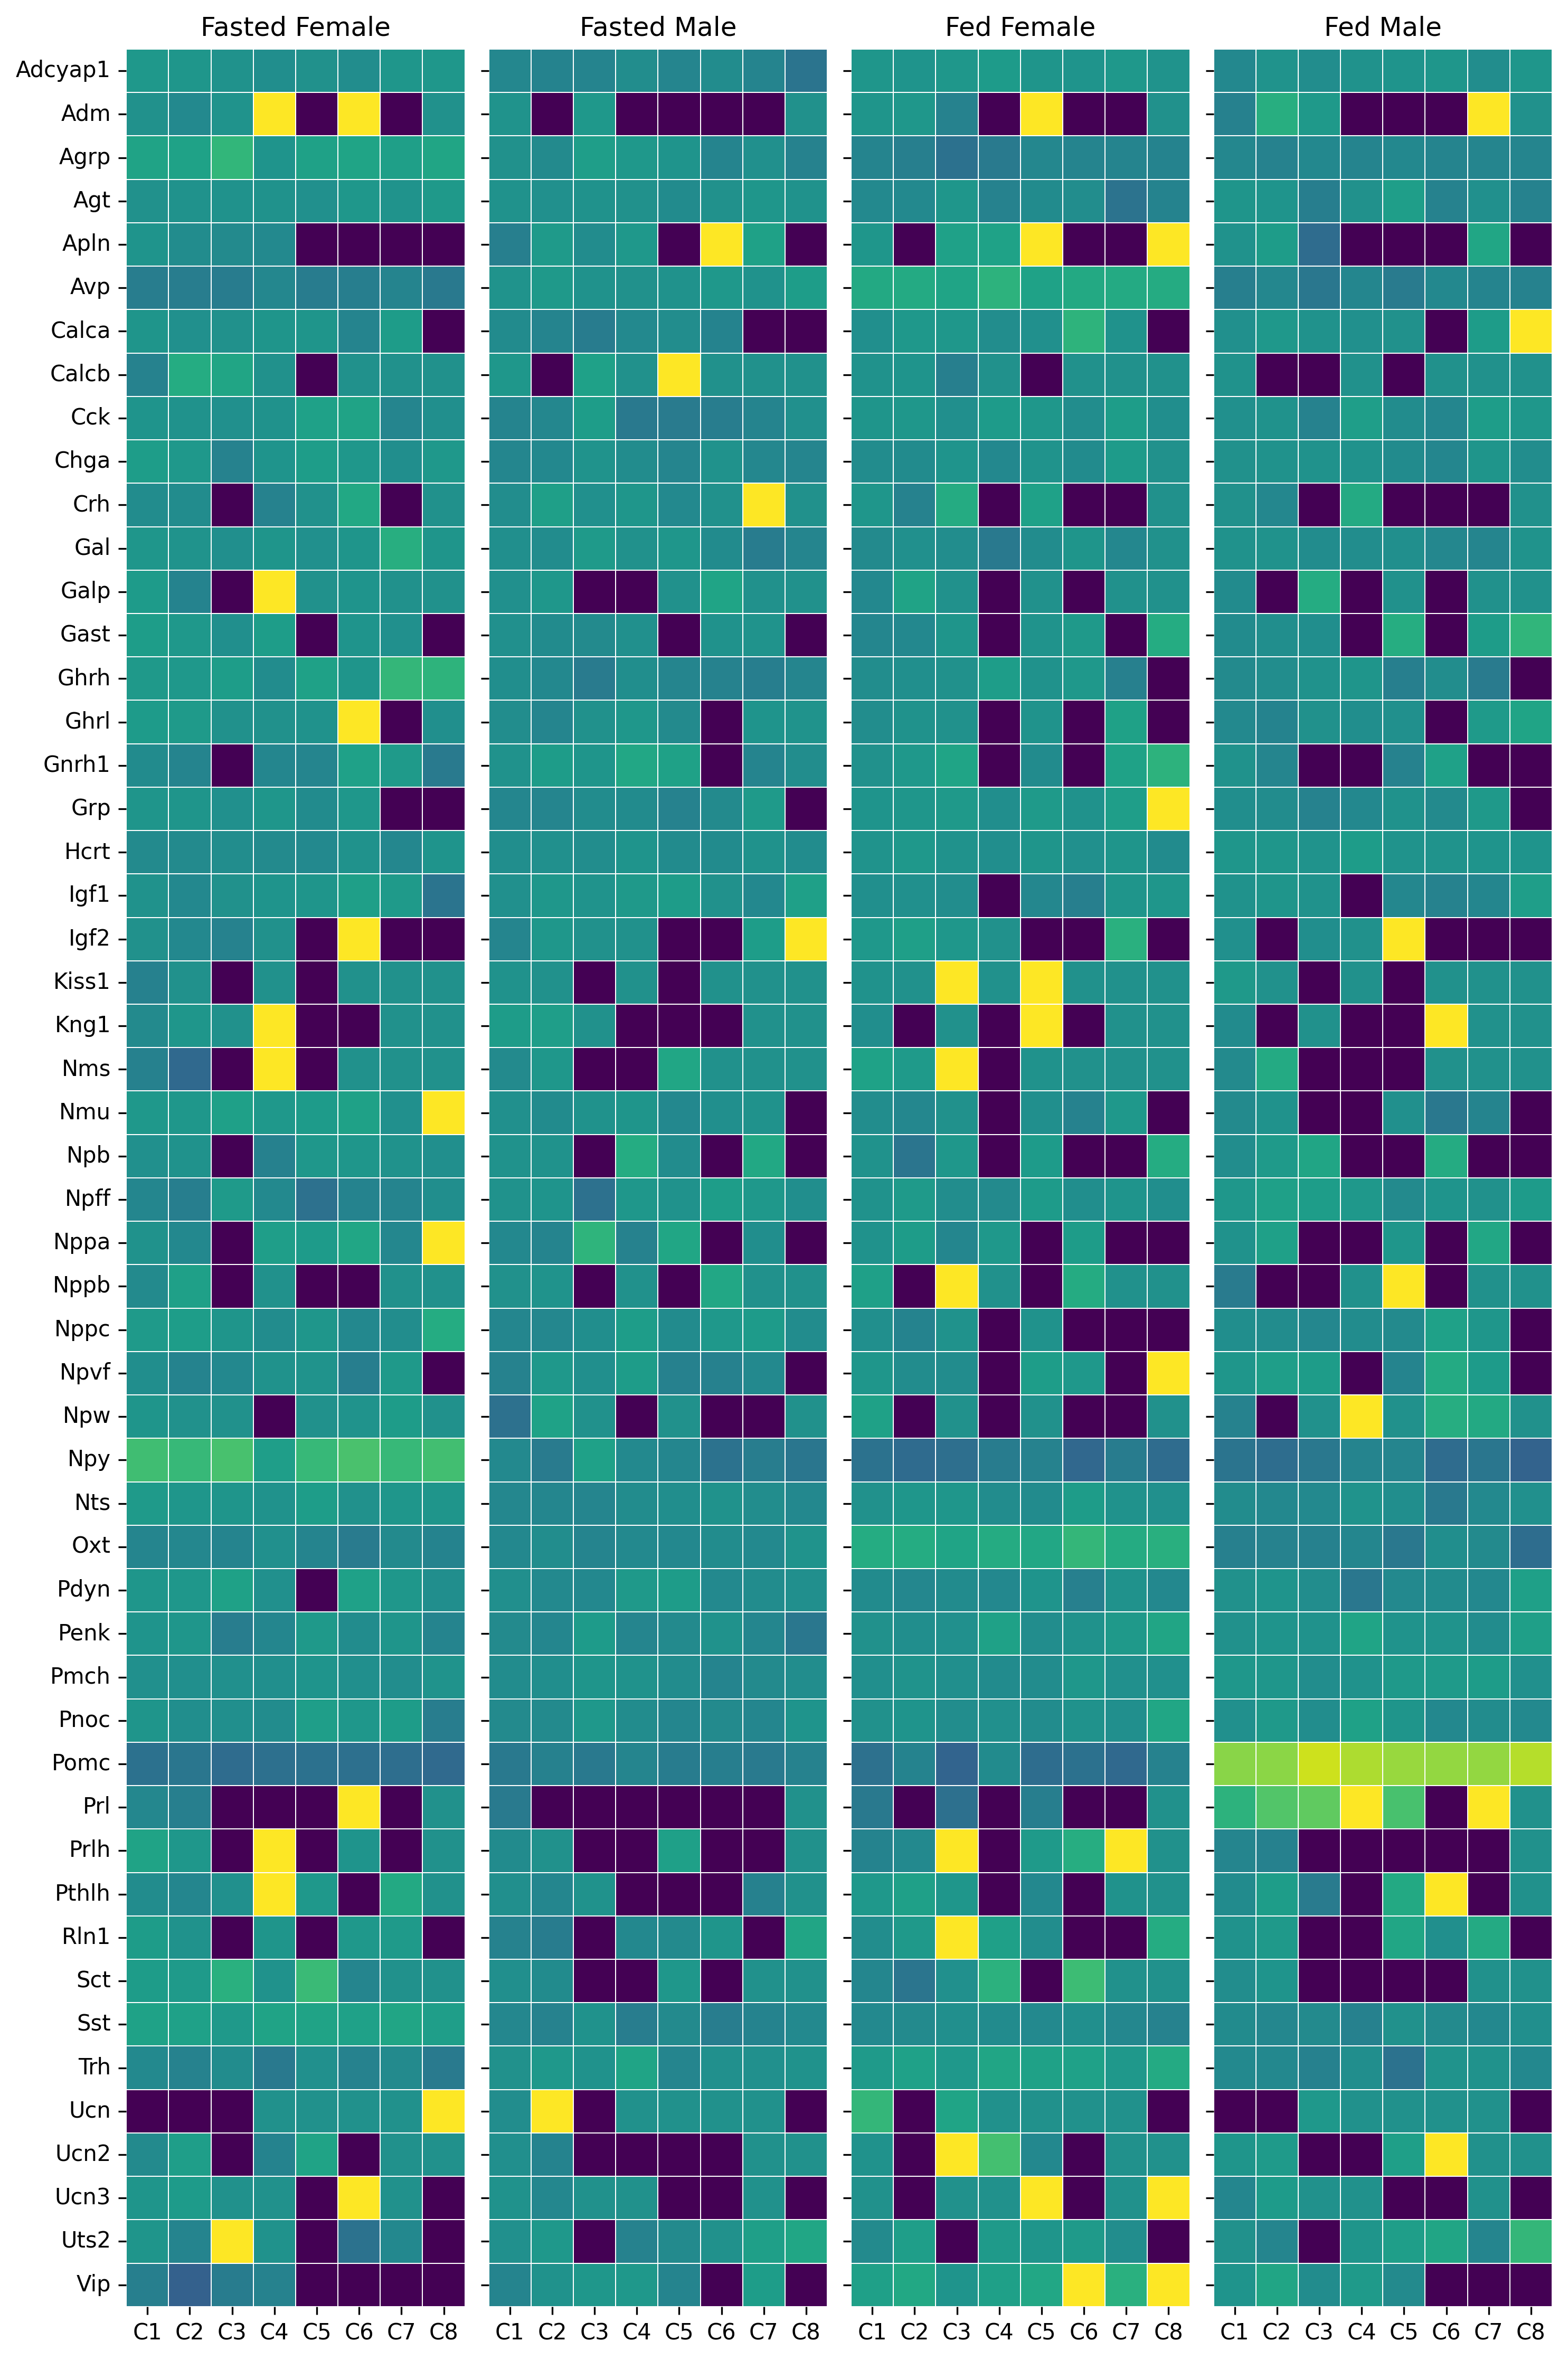

In [227]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 15
fig, axs = plt.subplots(1, 4, sharey=True)
axs = axs.ravel()

tickmap = { 
    'fasted_f' : 'Fasted Female',  
    'fasted_m' : 'Fasted Male',
    'fed_f' : 'Fed Female',  
    'fed_m': 'Fed Male',  
}


for i, (batch, group) in enumerate(res.groupby('group')):
    mat = pd.pivot_table(group, 
                         index='cluster',
                         columns='names',
                         values='logfoldchanges')

    # mat = sort_heatmap(mat, sort_rows=False)
    sns.heatmap(mat.T, 
                linecolor='w', 
                lw=0.1, 
                ax=axs[i],
                cmap='viridis',
                vmin=-10,
                vmax=10,
                cbar=False,
               )
    
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].tick_params(axis='y', rotation=0)
    axs[i].set_title(tickmap[batch])
    # break

plt.tight_layout()

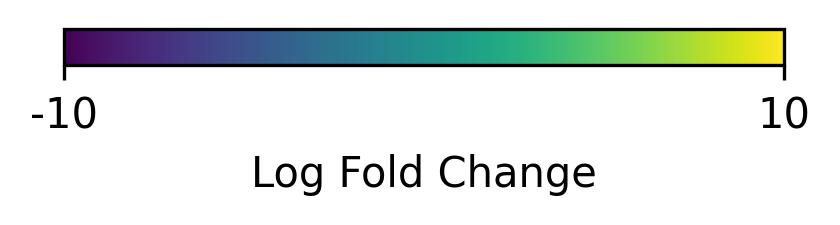

In [233]:
ut.makeColorbar('viridis', 3, 0.2, 'Log Fold Change', 'horizontal', ['-10', '10'])

In [228]:
?ut.makeColorbar

Signature: ut.makeColorbar(cmap, width, hieght, title, orientation, tickLabels)
Docstring: <no docstring>
File:      ~/git_repositories/MC3R/notebooks/utils.py
Type:      function

In [162]:
deg.columns

Index(['group', 'names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj',
       'Sex', 'Diet'],
      dtype='object')

/home/cstansbu/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Tue Apr 16 14:12:08 2024 WARNING posx and posy should be finite values
Tue Apr 16 14:12:08 2024 WARNING posx and posy should be finite values
Tue Apr 16 14:12:08 2024 WARNING posx and posy should be finite values
Tue Apr 16 14:12:08 2024 WARNING posx and posy should be finite values
Tue Apr 16 14:12:09 2024 WARNING posx and posy should be finite values
Tue Apr 16 14:12:09 2024 WARNING posx and posy should be finite values
Tue Apr 16 14:12:09 2024 WARNING posx and posy should be finite values
Tue Apr 16 14:12:09 2024 WARNING posx and posy should be finite values


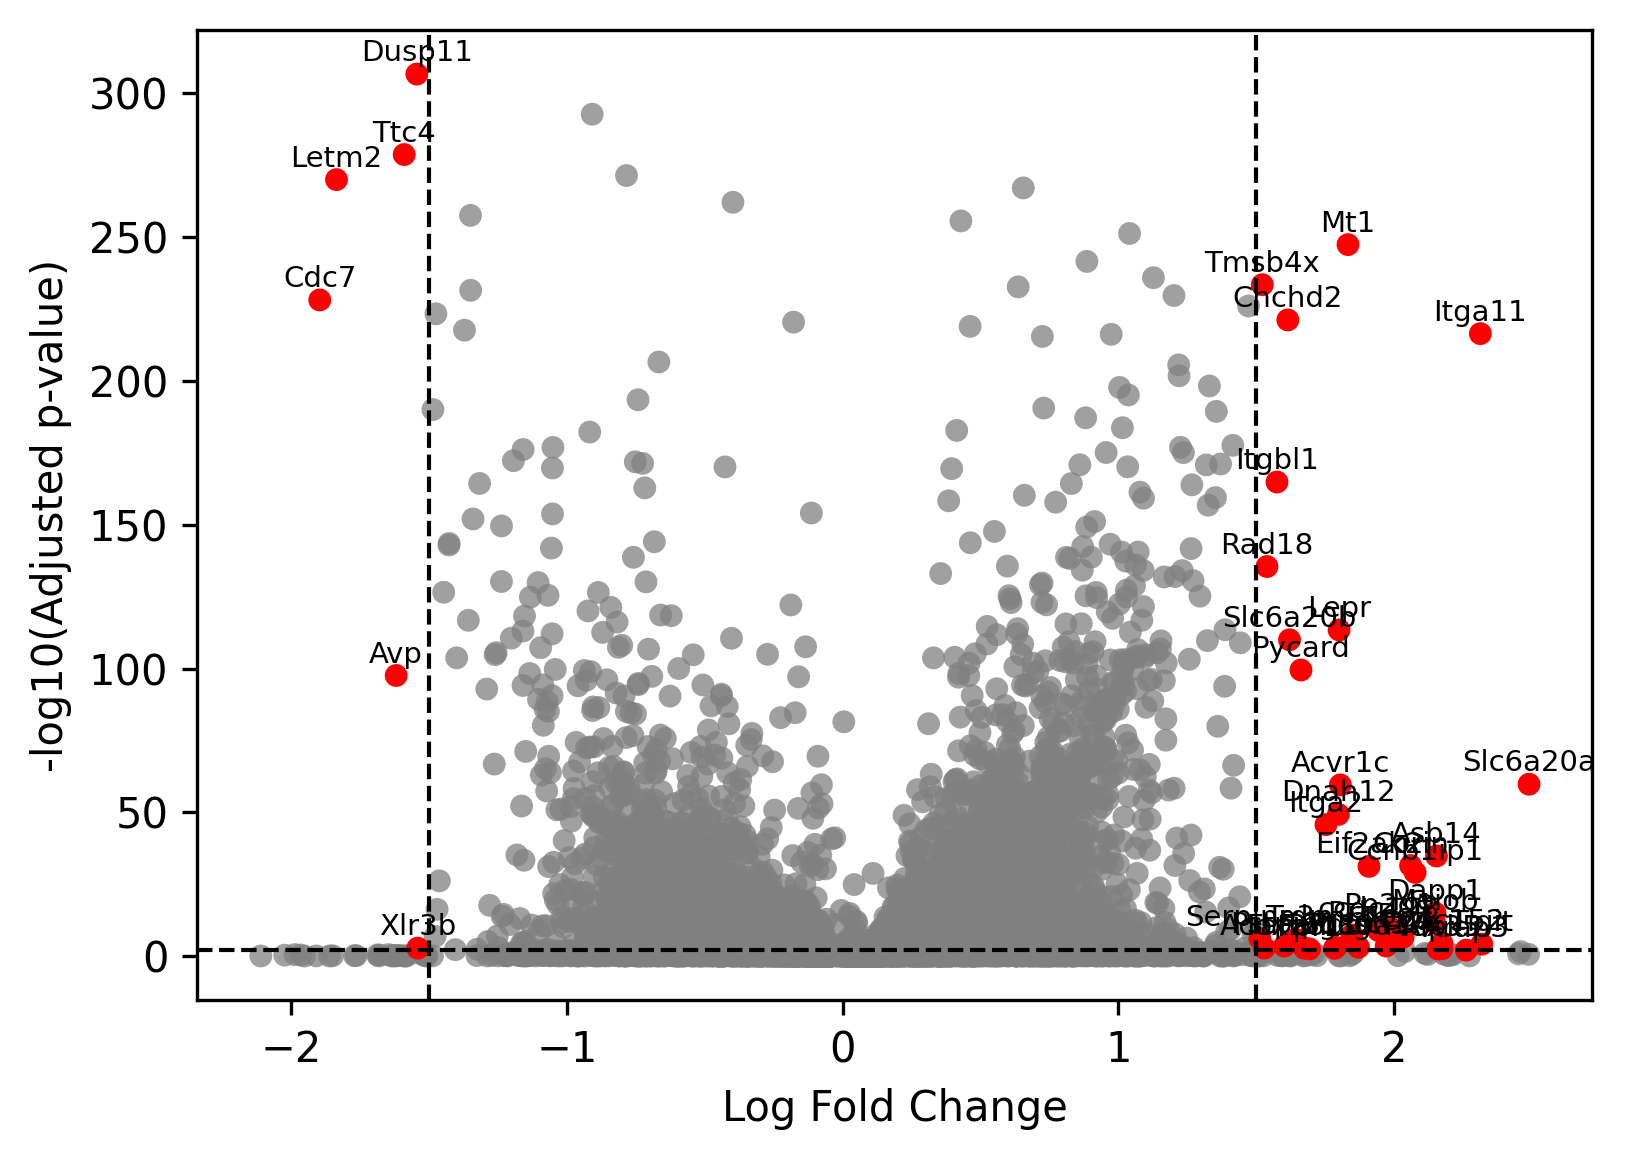

In [157]:
def create_volcano_plot(df, pval_threshold=0.05, logfc_threshold=1, 
                        min_logfc=None, max_logfc=None,
                        highlight_color='red'):
    """
    Creates an enhanced volcano plot with customizable visual parameters.

    Args:
        df (pandas.DataFrame): Input DataFrame containing gene expression data.
        pval_threshold (float): Log fold change threshold for significance (optional). 
                            Defaults to 0.05.
        logfc_threshold (float): Log fold change threshold for significance (optional). 
                             Defaults to 1.
        min_logfc (float): Minimum log fold change to display on the plot (optional).
        max_logfc (float): Maximum log fold change to display on the plot (optional).
        highlight_color (str): Color used for highlighting significant genes (optional). 
                               Defaults to 'red'.
    """                    
                            
    # filter out certain clases of genes
    df = df[(~df['names'].str.startswith("Gm")) &
            (~df['names'].str.startswith("mt")) &
            (~df['names'].str.endswith("Rik"))].reset_index(drop=True)
    
    # Calculate -log10(p-value)
    df['-log10(pval_adj)'] = -np.log10(df['pvals_adj']) 
    df = df[df['-log10(pval_adj)'] > 0.01]

    # Fold change thresholds
    if not min_logfc is None:
        df = df[df['logfoldchanges'] > min_logfc]
    if not max_logfc is None:
        df = df[df['logfoldchanges'] < max_logfc]

    # Filter significant genes 
    df_significant = df[
        (np.abs(df['logfoldchanges']) >= logfc_threshold) &
        (df['-log10(pval_adj)'] >= -np.log10(pval_threshold))
    ]
    df_not_significant = df[~df.index.isin(df_significant.index)]

    # Create the volcano plot (no figsize)
    plt.figure() 

    # Plot non-significant genes
    sns.scatterplot(data=df_not_significant, 
                    x='logfoldchanges', 
                    y='-log10(pval_adj)',
                    color='gray',
                    ec='none',
                    s=30,
                    alpha=0.75,
                    zorder=1,
                   ) 

    # Plot significant genes with highlighting
    sns.scatterplot(data=df_significant, 
                    x='logfoldchanges', 
                    y='-log10(pval_adj)',
                    color=highlight_color, 
                    ec='none',
                    s=30,
                    zorder=2,
                   )

    # Add labels for significant genes
    for i, row in df_significant.iterrows():
        plt.text(row['logfoldchanges'], 
                 row['-log10(pval_adj)'] + 4.5, 
                 row['names'], ha='center', 
                 fontsize=7)

    plt.xlabel('Log Fold Change')
    plt.ylabel('-log10(Adjusted p-value)')

    # Add significance lines
    plt.axvline(x=-logfc_threshold, 
                color='k',
                linestyle='--', 
                linewidth=1)
                            
    plt.axvline(x=logfc_threshold, 
                color='k',
                linestyle='--',
                linewidth=1)
                            
    plt.axhline(y=-np.log10(pval_threshold), 
                color='k', 
                linestyle='--',
                linewidth=1)
                            
    plt.show()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 4.2



for batch, group in deg.groupby('group'):

    create_volcano_plot(group, 
                        logfc_threshold=1.5,
                        pval_threshold=0.01,
                        min_logfc=-2.5, 
                        max_logfc=2.5)
    break

In [123]:
tickmap = { 
    'fasted_f' : 'Fasted Female',  
    'fasted_m' : 'Fasted Male',
    'fed_f' : 'Fed Female',  
    'fed_m': 'Fed Male',  
}